In [1]:
import pandas as pd
import numpy as np
import os

data_dir = './Data'

pd.set_option('display.max_rows', 150)

<b>Load data</b>

In [2]:
import geopandas as gpd

In [3]:
data_dir = './Data'
df = pd.read_csv(os.path.join(data_dir,'Trade_GDP_CalSuff.csv')).set_index('ISO3').drop(columns=['Unnamed: 0'])
df = df.rename({'GDP_ssp1_2010':'GDP_2010'},axis=1)
df['2013_Trade_Class'] = df['Trade_2013'].values

#0 = importer, 1 = exporter, 2 = else
for ind in range(len(df)):
    if df['2013_Trade_Class'][ind] < 0.1:
        df['2013_Trade_Class'][ind] = 0
    elif df['2013_Trade_Class'][ind] > 0.8:
        df['2013_Trade_Class'][ind] = 1
    else:
         df['2013_Trade_Class'][ind] = 2

<ipython-input-3-d30b6ebc9122>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = 2
<ipython-input-3-d30b6ebc9122>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = 0
<ipython-input-3-d30b6ebc9122>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = 1


# Modelling 2050 Trade Index Based on different years of past trade Index(2013, 2001, 1998)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [5]:
df['log_GDP_2010'] = df['GDP_2010'].apply(lambda x:np.log(x))
df = df.dropna()

In [6]:
def lin_reg(trade_out, comp_map_name):
    X = df[['Calsuff_2000','log_GDP_2010']]  
    y = df[trade_out] 

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    from sklearn.metrics import mean_squared_error
    from math import sqrt

    rms = sqrt(mean_squared_error(y_test, y_pred))
    print("RMS(Root Mean Squared Error) = ", rms)
    
    for i in np.arange(1,6):
        df['log_GDP_ssp'+str(i)] = df['GDP_ssp'+str(i)].apply(lambda x:np.log(x))
        
    for i in np.arange(1,6):
        df['Trade_lm_predicted_ssp'+str(i)] = regressor.predict(df[['Calsuff_ssp'+str(i),'log_GDP_ssp'+str(i)]])
        
    import geopandas
    import matplotlib.pyplot as plt
    import matplotlib.colors
    #import geoplot

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world.set_index("iso_a3").merge(df)
    
    # Colormap
    levels = [0, 0.2, 0.4, 0.6, 0.8, 0.99,1.01]
    colors = ['#dadaeb', '#9e9ac8', '#756bb1', '#54278f','#3f007d','black']
    cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

    fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20, 10))

    world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
    axes[0,0].set_title('Approximated trade Indep SSP1 2050', fontdict={'fontsize':'16'});
    axes[0,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
    axes[1,0].set_title('Approximated trade Indep SSP2 2050', fontdict={'fontsize':'16'});
    axes[1,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
    axes[2,0].set_title('Approximated trade Indep SSP3 2050', fontdict={'fontsize':'16'});
    axes[2,0].axis('off');


    world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
    axes[0,1].set_title('Approximated trade Indep SSP4 2050', fontdict={'fontsize':'16'});
    axes[0,1].axis('off');

    world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
    axes[1,1].set_title('Approximated trade Indep SSP5 2050', fontdict={'fontsize':'16'});
    axes[1,1].axis('off');

    world.plot(column=trade_out, cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
    axes[2,1].set_title(comp_map_name, fontdict={'fontsize':'16'});
    axes[2,1].axis('off');

In [7]:
def randForClass_2013():
    X = df[['Calsuff_2000','log_GDP_2010']]  
    y = df['2013_Trade_Class'] 

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    from sklearn.ensemble import RandomForestClassifier

    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    print("Accuracy = ", accuracy)
    for i in np.arange(1,6):
        df['log_GDP_ssp'+str(i)] = df['GDP_ssp'+str(i)].apply(lambda x:np.log(x))
        
    for i in np.arange(1,6):
        df['Trade_lm_predicted_ssp'+str(i)] = classifier.predict(df[['Calsuff_ssp'+str(i),'log_GDP_ssp'+str(i)]])
        
    import geopandas
    import matplotlib.pyplot as plt
    import matplotlib.colors
    #import geoplot

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world.set_index("iso_a3").merge(df)
    
    # Colormap
    colorsList = ['red', 'yellow', 'green']
    cmap = matplotlib.colors.ListedColormap(colorsList)
    fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20, 10))
    
    fig.suptitle('Green: Medium, Yellow: Exporter, Red: Importer', fontsize=16)

    world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap,  linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
    axes[0,0].set_title('Approximated trade Indep SSP1 2050', fontdict={'fontsize':'16'});
    axes[0,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
    axes[1,0].set_title('Approximated trade Indep SSP2 2050', fontdict={'fontsize':'16'});
    axes[1,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
    axes[2,0].set_title('Approximated trade Indep SSP3 2050', fontdict={'fontsize':'16'});
    axes[2,0].axis('off');


    world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
    axes[0,1].set_title('Approximated trade Indep SSP4 2050', fontdict={'fontsize':'16'});
    axes[0,1].axis('off');

    world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
    axes[1,1].set_title('Approximated trade Indep SSP5 2050', fontdict={'fontsize':'16'});
    axes[1,1].axis('off');

    world.plot(column='2013_Trade_Class', cmap=cmap, linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
    axes[2,1].set_title('Trade indep 2013 (Kummu, 2020)', fontdict={'fontsize':'16'});
    axes[2,1].axis('off');

## Compare 2050 Predictions(trained on 2013 trade index) with 2013 Trade Index

RMS(Root Mean Squared Error) =  0.2788803872041398


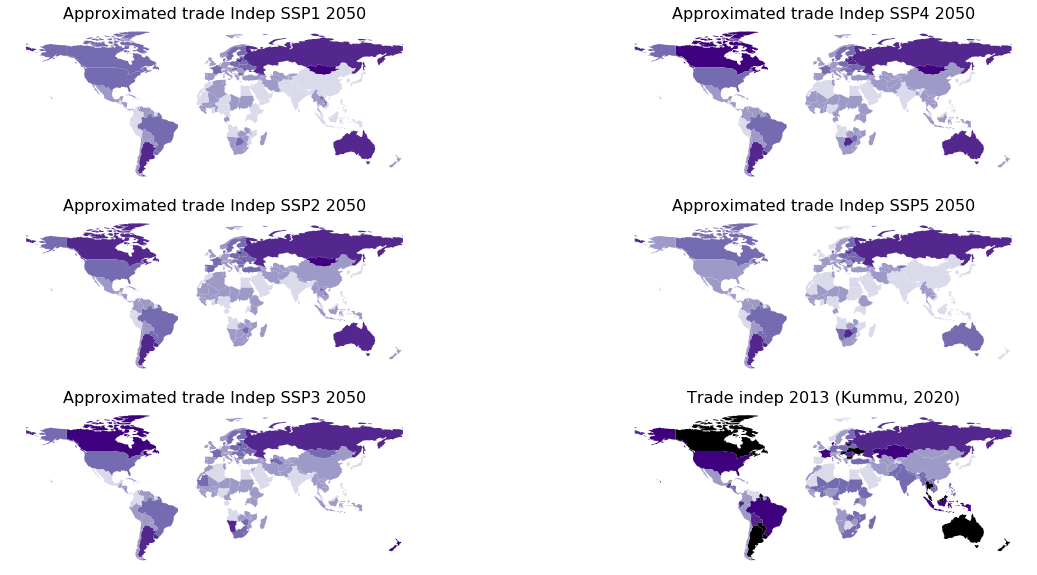

In [8]:
lin_reg('Trade_2013', 'Trade indep 2013 (Kummu, 2020)')

In [9]:
temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_2013','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_2013= temp.copy()

Accuracy =  0.6896551724137931


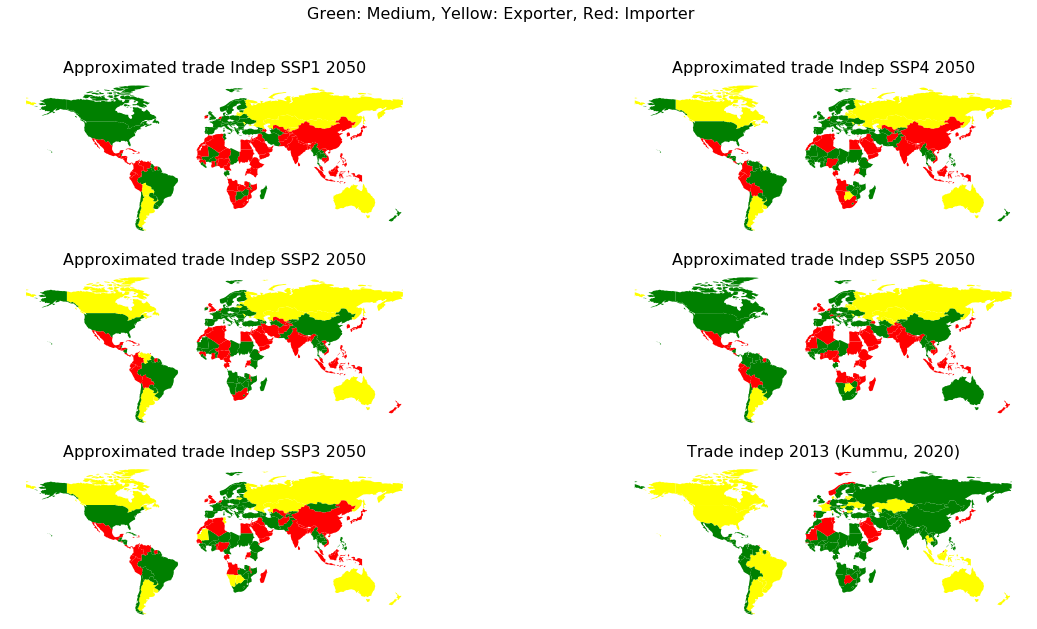

In [10]:
randForClass_2013()

In [11]:
temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_2013','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_2013= temp.copy()

## Importer-Exporter Analysis

### Within the countries exporters in 2013, how many remain exporters in 2050?

In [12]:
#xx remain exporters under all scenarios
remain_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp.append(predicted_2013['name'][ind])
print(len(remain_exp), " countries remain exporters from 2013 to 2050 in all SSPs", remain_exp);
print()

#xx remain exporters only in some scenarios
remain_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp1.append(predicted_2013['name'][ind])
print(len(remain_exp1), " countries remain exporters from 2013 to 2050 in SSP1", remain_exp1);
print()

remain_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp2.append(predicted_2013['name'][ind])
print(len(remain_exp2), " countries remain exporters from 2013 to 2050 in SSP2", remain_exp2);
print()

remain_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp3.append(predicted_2013['name'][ind])
print(len(remain_exp3), " countries remain exporters from 2013 to 2050 in SSP3", remain_exp3);
print()

remain_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp4.append(predicted_2013['name'][ind])
print(len(remain_exp4), " countries remain exporters from 2013 to 2050 in SSP4", remain_exp4);
print()

remain_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp5.append(predicted_2013['name'][ind])
print(len(remain_exp5), " countries remain exporters from 2013 to 2050 in SSP5", remain_exp5);
print()

#xx NOT remain exporters under all scenarios
remain_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 1 and predicted_2013['Trade_lm_predicted_ssp2'][ind] != 1 and predicted_2013['Trade_lm_predicted_ssp3'][ind] != 1 and predicted_2013['Trade_lm_predicted_ssp4'][ind] != 1 and predicted_2013['Trade_lm_predicted_ssp5'][ind] != 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp.append(predicted_2013['name'][ind])
print(len(remain_exp), " countries do not remain exporters from 2013 to 2050 in all SSPs", remain_exp);
print()

#xx NOT remain exporters only in some scenarios
remain_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp1.append(predicted_2013['name'][ind])
print(len(remain_exp1), " countries do not remain exporters from 2013 to 2050 in SSP1", remain_exp1);
print()

remain_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] != 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp2.append(predicted_2013['name'][ind])
print(len(remain_exp2), " countries do not remain exporters from 2013 to 2050 in SSP2", remain_exp2);
print()

remain_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] != 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp3.append(predicted_2013['name'][ind])
print(len(remain_exp3), "countries do not remain exporters from 2013 to 2050 in SSP3", remain_exp3);
print()

remain_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] != 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp4.append(predicted_2013['name'][ind])
print(len(remain_exp4), "countries remain exporters from 2013 to 2050 in SSP4", remain_exp4);
print()

remain_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] != 1 and df['2013_Trade_Class'][ind] == 1:
        remain_exp5.append(predicted_2013['name'][ind])
print(len(remain_exp5), "countries do not remain exporters from 2013 to 2050 in SSP5", remain_exp5);
print()

#xx become new exporters
new_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 1 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 1 and df['2013_Trade_Class'][ind] != 1:        
        new_exp.append(predicted_2013['name'][ind])
print(len(new_exp), " countries become new exporters from 2013 to 2050 in all SSPs", new_exp);
print()

#xx become exporters only in some scenarios
new_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 1 and df['2013_Trade_Class'][ind] != 1:
        new_exp1.append(predicted_2013['name'][ind])
print(len(new_exp1), " countries become new exporters from 2013 to 2050 in SSP1", new_exp1);
print()

new_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 1 and df['2013_Trade_Class'][ind] != 1:
        new_exp2.append(predicted_2013['name'][ind])
print(len(new_exp2), " countries become new exporters from 2013 to 2050 in SSP2", new_exp2);
print()

new_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 1 and df['2013_Trade_Class'][ind] != 1:
        new_exp3.append(predicted_2013['name'][ind])
print(len(new_exp3), " countries become new exporters from 2013 to 2050 in SSP3", new_exp3);
print()

new_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 1 and df['2013_Trade_Class'][ind] != 1:
        new_exp4.append(predicted_2013['name'][ind])
print(len(new_exp4), " countries become new exporters from 2013 to 2050 in SSP4", new_exp4);
print()

new_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 1 and df['2013_Trade_Class'][ind] != 1:
        new_exp5.append(predicted_2013['name'][ind])
print(len(new_exp5), " countries become new exporters from 2013 to 2050 in SSP5", new_exp5);
print()

3  countries remain exporters from 2013 to 2050 in all SSPs ['Argentina', 'Kazakhstan', 'Lithuania']

5  countries remain exporters from 2013 to 2050 in SSP1 ['Argentina', 'Australia', 'Kazakhstan', 'Lithuania', 'Latvia']

6  countries remain exporters from 2013 to 2050 in SSP2 ['Argentina', 'Australia', 'Canada', 'Kazakhstan', 'Lithuania', 'Uruguay']

7  countries remain exporters from 2013 to 2050 in SSP3 ['Argentina', 'Australia', 'Canada', 'Kazakhstan', 'Lithuania', 'New Zealand', 'Uruguay']

7  countries remain exporters from 2013 to 2050 in SSP4 ['Argentina', 'Australia', 'Canada', 'Kazakhstan', 'Lithuania', 'Latvia', 'Uruguay']

5  countries remain exporters from 2013 to 2050 in SSP5 ['Argentina', 'Kazakhstan', 'Lithuania', 'Latvia', 'Uruguay']

13  countries do not remain exporters from 2013 to 2050 in all SSPs ['Bulgaria', 'Belize', 'Brazil', 'Denmark', 'France', 'Guyana', 'Hungary', 'Indonesia', 'Malaysia', 'Paraguay', 'Thailand', 'Ukraine', 'United States of America']

16  c

### Within the countries importers in 2013, how many remain importers in 2050?

In [13]:
#xx remain importers under all scenarios
remain_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp.append(predicted_2013['name'][ind])
print(len(remain_imp), " countries remain importers from 2013 to 2050 in all SSPs", remain_imp);
print()

#xx remain importers only in some scenarios
remain_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp1.append(predicted_2013['name'][ind])
print(len(remain_imp1), " countries remain importers from 2013 to 2050 in SSP1", remain_imp1);
print()

remain_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp2.append(predicted_2013['name'][ind])
print(len(remain_imp2), " countries remain importers from 2013 to 2050 in SSP2", remain_imp2);
print()

remain_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp3.append(predicted_2013['name'][ind])
print(len(remain_imp3), " countries remain importers from 2013 to 2050 in SSP3", remain_imp3);
print()

remain_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp4.append(predicted_2013['name'][ind])
print(len(remain_imp4), " countries remain importers from 2013 to 2050 in SSP4", remain_imp4);
print()

remain_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp5.append(predicted_2013['name'][ind])
print(len(remain_imp5), " countries remain importers from 2013 to 2050 in SSP5", remain_imp5);
print()

#xx NOT remain importers under all scenarios
remain_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp2'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp3'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp4'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp5'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp.append(predicted_2013['name'][ind])
print(len(remain_imp), " countries do not remain importers from 2013 to 2050 in all SSPs", remain_imp);
print()

#xx NOT remain importers only in some scenarios
remain_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp1.append(predicted_2013['name'][ind])
print(len(remain_imp1), " countries do not remain importers from 2013 to 2050 in SSP1", remain_imp1);
print()

remain_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp2.append(predicted_2013['name'][ind])
print(len(remain_imp2), " countries do not remain importers from 2013 to 2050 in SSP2", remain_imp2);
print()

remain_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp3.append(predicted_2013['name'][ind])
print(len(remain_imp3), "countries do not remain importers from 2013 to 2050 in SSP3", remain_imp3);
print()

remain_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp4.append(predicted_2013['name'][ind])
print(len(remain_imp4), "countries remain importers from 2013 to 2050 in SSP4", remain_imp4);
print()

remain_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp5.append(predicted_2013['name'][ind])
print(len(remain_imp5), "countries do not remain importers from 2013 to 2050 in SSP5", remain_imp5);
print()

#xx become new importers
new_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:        
        new_imp.append(predicted_2013['name'][ind])
print(len(new_imp), " countries become new importers from 2013 to 2050 in all SSPs", new_imp);
print()

#xx become importers only in some scenarios
new_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp1.append(predicted_2013['name'][ind])
print(len(new_imp1), " countries become new importers from 2013 to 2050 in SSP1", new_imp1);
print()

new_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp2.append(predicted_2013['name'][ind])
print(len(new_imp2), " countries become new importers from 2013 to 2050 in SSP2", new_imp2);
print()

new_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp3.append(predicted_2013['name'][ind])
print(len(new_imp3), " countries become new importers from 2013 to 2050 in SSP3", new_imp3);
print()

new_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp4.append(predicted_2013['name'][ind])
print(len(new_imp4), " countries become new importers from 2013 to 2050 in SSP4", new_imp4);
print()

new_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp5.append(predicted_2013['name'][ind])
print(len(new_imp5), " countries become new importers from 2013 to 2050 in SSP5", new_imp5);
print()



15  countries remain importers from 2013 to 2050 in all SSPs ['United Arab Emirates', 'Brunei', 'Djibouti', 'Algeria', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Netherlands', 'Saudi Arabia', 'Trinidad and Tobago', 'Yemen']

18  countries remain importers from 2013 to 2050 in SSP1 ['United Arab Emirates', 'Brunei', 'Cyprus', 'Djibouti', 'Algeria', 'Gambia', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Mauritania', 'Netherlands', 'Saudi Arabia', 'Trinidad and Tobago', 'Yemen']

16  countries remain importers from 2013 to 2050 in SSP2 ['United Arab Emirates', 'Brunei', 'Djibouti', 'Algeria', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Netherlands', 'Saudi Arabia', 'Trinidad and Tobago', 'Tunisia', 'Yemen']

17  countries remain importers from 2013 to 2050 in SSP3 ['United Arab Emirates', 'Brunei', 'Cyprus', 'Djibouti', 'Algeria', 'Gambia', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait'

## Compare 2050 Predictions(trained on 2001 trade index) with 2001 Trade Index

RMS(Root Mean Squared Error) =  0.23937078948630955


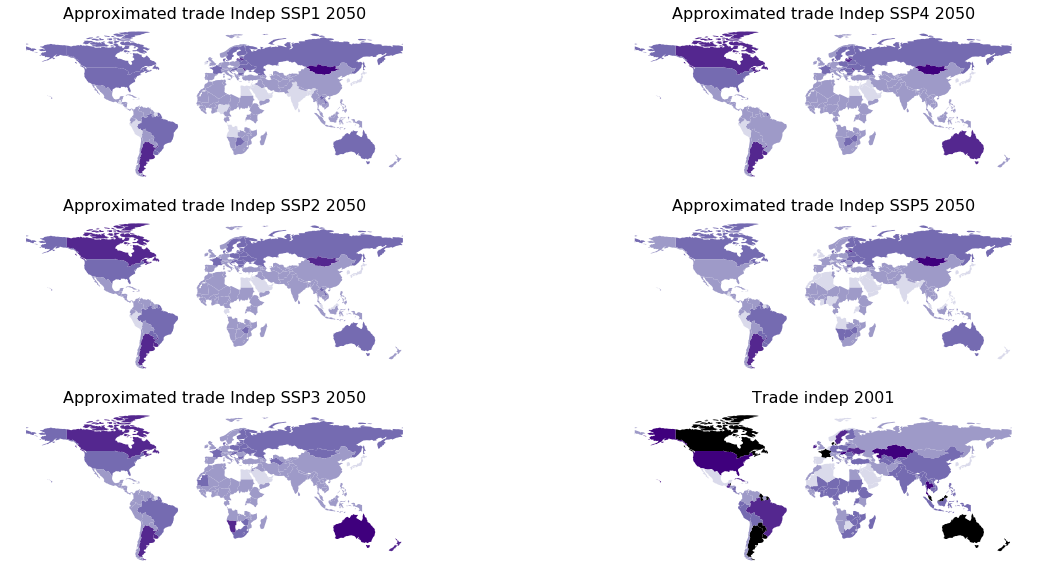

In [14]:
lin_reg('Trade_2001', 'Trade indep 2001')

In [15]:
temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_2001','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_2001= temp.copy()

## Compare 2050 Predictions(trained on 1998 trade index) with 1998 Trade Index

RMS(Root Mean Squared Error) =  0.2313309140231337


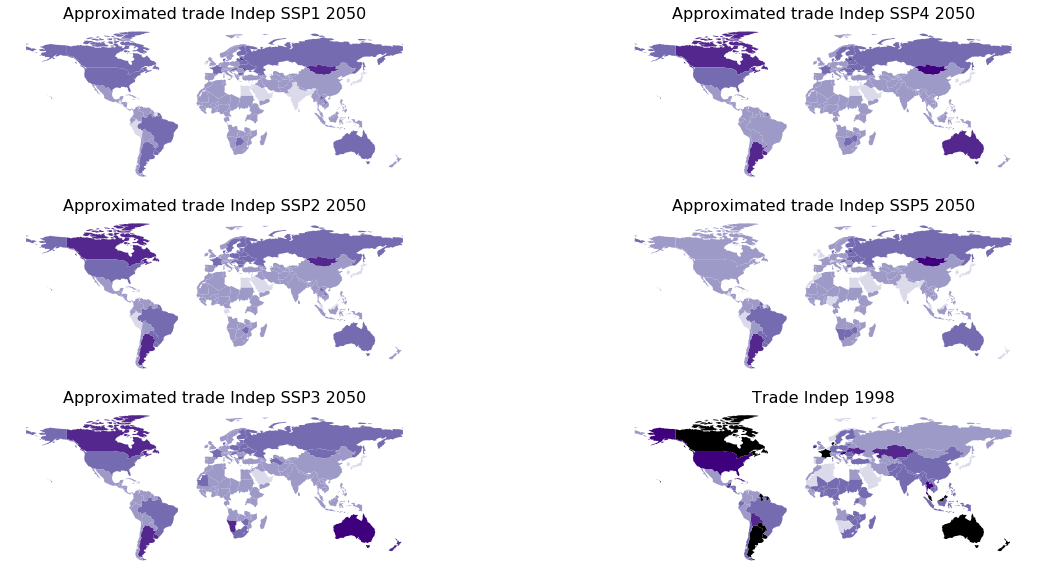

In [16]:
lin_reg('Trade_1998', 'Trade Indep 1998')

In [17]:
temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_1998','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_1998= temp.copy()

# Comparing the Predictions Made Based on Different Years

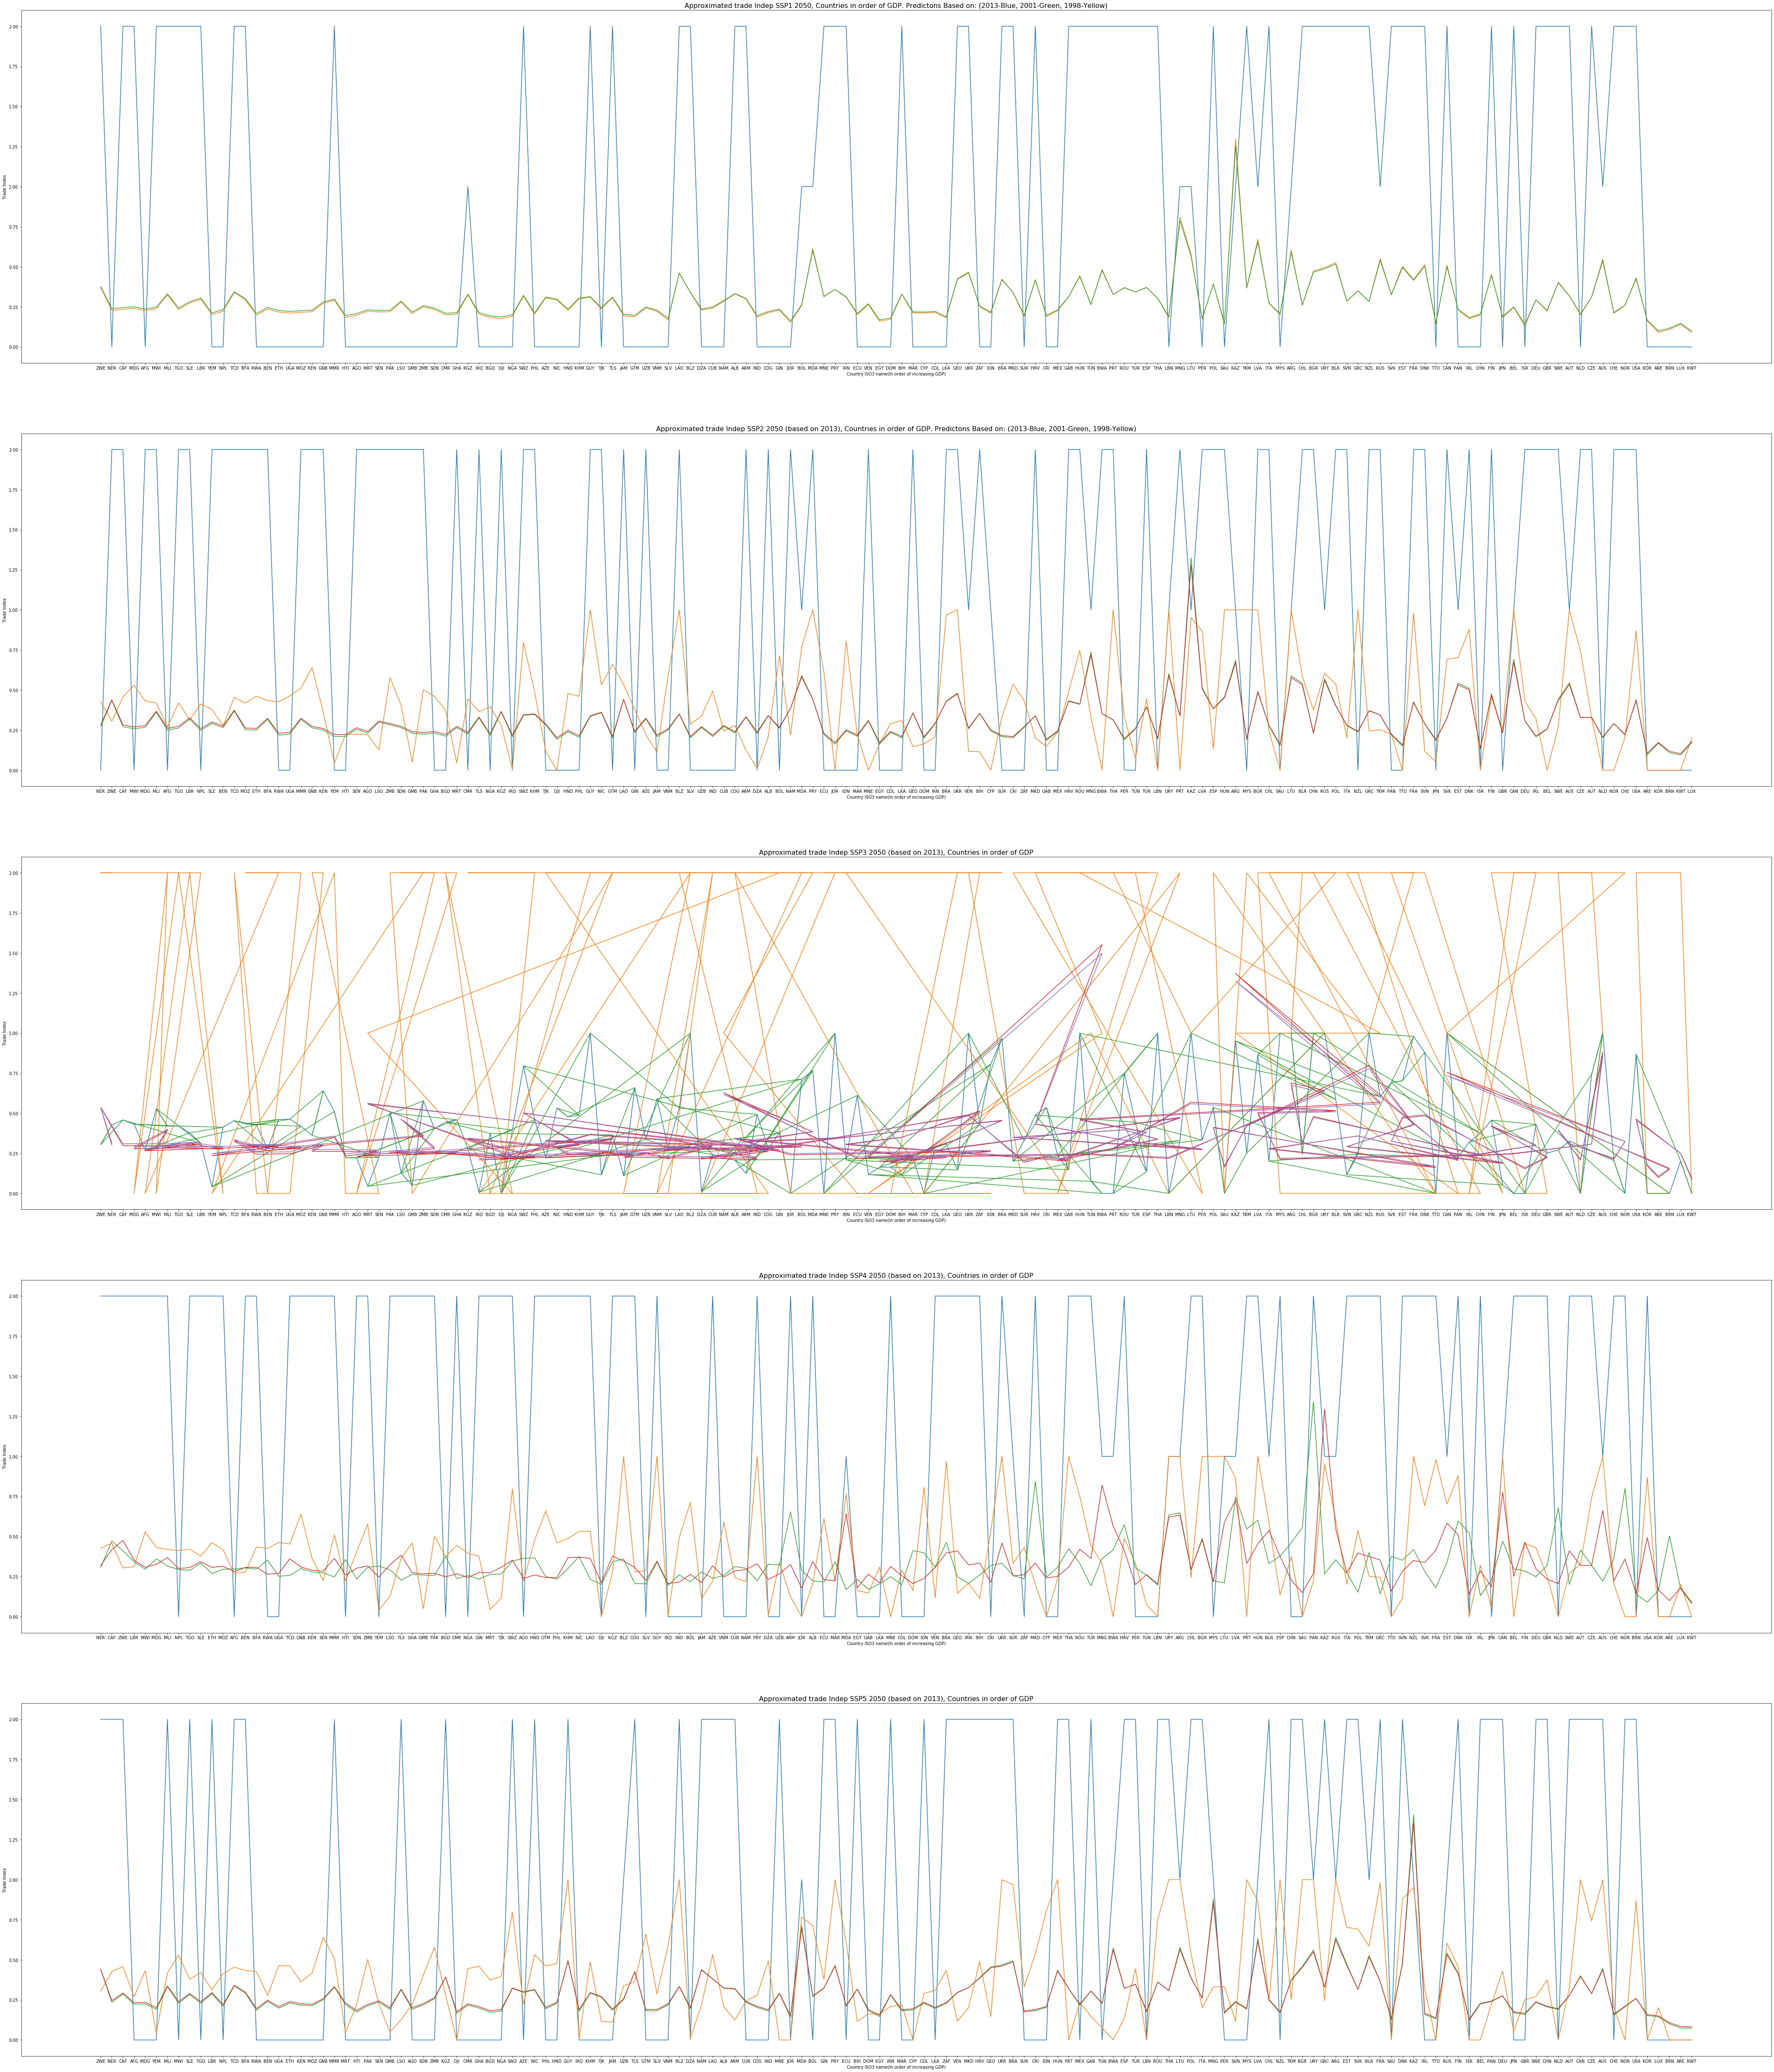

In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
fig, axes = plt.subplots(5, 1,  figsize=(75, 90)) 
#SSP 1
axes[0].set_title('Approximated trade Indep SSP1 2050, Countries in order of GDP. Predictons Based on: (2013-Blue, 2001-Green, 1998-Yellow)', fontdict={'fontsize':'16'});
predicted_2013_GDP_1= predicted_2013.sort_values(by=['GDP_ssp1'])
predicted_2013_GDP_1['name_ind']= predicted_2013_GDP_1.index
axes[0].plot(predicted_2013_GDP_1['name_ind'], predicted_2013_GDP_1['Trade_lm_predicted_ssp1'])
axes[2].plot(predicted_2013_GDP_1['name_ind'], predicted_2013_GDP_1['Trade_2013'])


predicted_2001_GDP_1= predicted_2001.sort_values(by=['GDP_ssp1'])
predicted_2001_GDP_1['name_ind']= predicted_2001_GDP_1.index
axes[0].plot(predicted_2001_GDP_1['name_ind'], predicted_2001_GDP_1['Trade_lm_predicted_ssp1'])

predicted_1998_GDP_1= predicted_1998.sort_values(by=['GDP_ssp1'])
predicted_1998_GDP_1['name_ind']= predicted_1998_GDP_1.index
axes[0].plot(predicted_1998_GDP_1['name_ind'], predicted_1998_GDP_1['Trade_lm_predicted_ssp1'])

axes[0].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[0].set_ylabel("Trade Index")

#SSP 2
axes[1].set_title('Approximated trade Indep SSP2 2050 (based on 2013), Countries in order of GDP. Predictons Based on: (2013-Blue, 2001-Green, 1998-Yellow)', fontdict={'fontsize':'16'});
predicted_2013_GDP_2= predicted_2013.sort_values(by=['GDP_ssp2'])
predicted_2013_GDP_2['name_ind']= predicted_2013_GDP_2.index
axes[1].plot(predicted_2013_GDP_2['name_ind'], predicted_2013_GDP_2['Trade_lm_predicted_ssp2'])
axes[1].plot(predicted_2013_GDP_2['name_ind'], predicted_2013_GDP_2['Trade_2013'])


predicted_2001_GDP_2= predicted_2001.sort_values(by=['GDP_ssp2'])
predicted_2001_GDP_2['name_ind']= predicted_2001_GDP_2.index
axes[1].plot(predicted_2001_GDP_2['name_ind'], predicted_2001_GDP_2['Trade_lm_predicted_ssp2'])

predicted_1998_GDP_2= predicted_1998.sort_values(by=['GDP_ssp2'])
predicted_1998_GDP_2['name_ind']= predicted_1998_GDP_2.index
axes[1].plot(predicted_1998_GDP_2['name_ind'], predicted_1998_GDP_2['Trade_lm_predicted_ssp2'])

axes[1].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[1].set_ylabel("Trade Index")

#SSP 3
axes[2].set_title('Approximated trade Indep SSP3 2050 (based on 2013), Countries in order of GDP', fontdict={'fontsize':'16'});
predicted_2013_GDP_3= predicted_2013.sort_values(by=['GDP_ssp3'])
predicted_2013_GDP_3['name_ind']= predicted_2013_GDP_3.index
axes[2].plot(predicted_2013_GDP_3['name_ind'], predicted_2013_GDP_3['Trade_lm_predicted_ssp3'])
axes[2].plot(predicted_2013_GDP_3['name_ind'], predicted_2013_GDP_3['Trade_2013'])


predicted_2001_GDP_3= predicted_2001.sort_values(by=['GDP_ssp3'])
predicted_2001_GDP_3['name_ind']= predicted_2001_GDP_3.index
axes[2].plot(predicted_2001_GDP_3['name_ind'], predicted_2001_GDP_3['Trade_lm_predicted_ssp3'])

predicted_1998_GDP_3= predicted_1998.sort_values(by=['GDP_ssp3'])
predicted_1998_GDP_3['name_ind']= predicted_1998_GDP_3.index
axes[2].plot(predicted_1998_GDP_3['name_ind'], predicted_1998_GDP_3['Trade_lm_predicted_ssp3'])

axes[2].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[2].set_ylabel("Trade Index")

#SSP 4
axes[3].set_title('Approximated trade Indep SSP4 2050 (based on 2013), Countries in order of GDP', fontdict={'fontsize':'16'});
predicted_2013_GDP_4= predicted_2013.sort_values(by=['GDP_ssp4'])
predicted_2013_GDP_4['name_ind']= predicted_2013_GDP_4.index
axes[3].plot(predicted_2013_GDP_4['name_ind'], predicted_2013_GDP_4['Trade_lm_predicted_ssp4'])
axes[3].plot(predicted_2013_GDP_4['name_ind'], predicted_2013_GDP_4['Trade_2013'])


predicted_2001_GDP_4= predicted_2001.sort_values(by=['GDP_ssp4'])
predicted_2001_GDP_4['name_ind']= predicted_2001_GDP_4.index
axes[3].plot(predicted_2001_GDP_4['name_ind'], predicted_2001_GDP_3['Trade_lm_predicted_ssp4'])

predicted_1998_GDP_4= predicted_1998.sort_values(by=['GDP_ssp4'])
predicted_1998_GDP_4['name_ind']= predicted_1998_GDP_4.index
axes[3].plot(predicted_1998_GDP_4['name_ind'], predicted_1998_GDP_4['Trade_lm_predicted_ssp4'])

axes[3].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[3].set_ylabel("Trade Index")

#SSP 5
axes[4].set_title('Approximated trade Indep SSP5 2050 (based on 2013), Countries in order of GDP', fontdict={'fontsize':'16'});
predicted_2013_GDP_5= predicted_2013.sort_values(by=['GDP_ssp5'])
predicted_2013_GDP_5['name_ind']= predicted_2013_GDP_5.index
axes[4].plot(predicted_2013_GDP_5['name_ind'], predicted_2013_GDP_5['Trade_lm_predicted_ssp5'])
axes[4].plot(predicted_2013_GDP_5['name_ind'], predicted_2013_GDP_5['Trade_2013'])


predicted_2001_GDP_5= predicted_2001.sort_values(by=['GDP_ssp5'])
predicted_2001_GDP_5['name_ind']= predicted_2001_GDP_5.index
axes[4].plot(predicted_2001_GDP_5['name_ind'], predicted_2001_GDP_5['Trade_lm_predicted_ssp5'])

predicted_1998_GDP_5= predicted_1998.sort_values(by=['GDP_ssp5'])
predicted_1998_GDP_5['name_ind']= predicted_1998_GDP_5.index
axes[4].plot(predicted_1998_GDP_5['name_ind'], predicted_1998_GDP_5['Trade_lm_predicted_ssp5'])

axes[4].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[4].set_ylabel("Trade Index")
plt.show()

# Grayscale Sample of Map

In [19]:
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors
#import geoplot

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.set_index("iso_a3").merge(df)

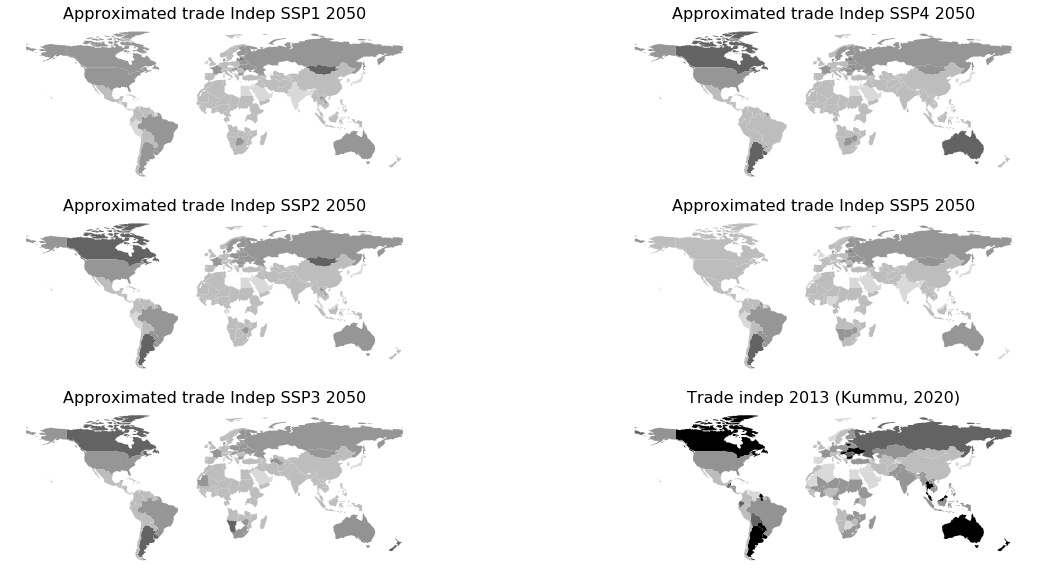

In [20]:
# Colormap
levels = [0, 0.2, 0.4, 0.6, 0.8, 0.99,1.01]
colors = ['#d9d9d9', '#bdbdbd', '#969696','#636363','252525','black']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

# Map predicted Trade 2050 and Trade 2013.

fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20, 10))

world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
axes[0,0].set_title('Approximated trade Indep SSP1 2050', fontdict={'fontsize':'16'});
axes[0,0].axis('off');

world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
axes[1,0].set_title('Approximated trade Indep SSP2 2050', fontdict={'fontsize':'16'});
axes[1,0].axis('off');

world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
axes[2,0].set_title('Approximated trade Indep SSP3 2050', fontdict={'fontsize':'16'});
axes[2,0].axis('off');


world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
axes[0,1].set_title('Approximated trade Indep SSP4 2050', fontdict={'fontsize':'16'});
axes[0,1].axis('off');

world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
axes[1,1].set_title('Approximated trade Indep SSP5 2050', fontdict={'fontsize':'16'});
axes[1,1].axis('off');

world.plot(column='Trade_2013', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
axes[2,1].set_title('Trade indep 2013 (Kummu, 2020)', fontdict={'fontsize':'16'});
axes[2,1].axis('off');